# An Introduction to Conformal Prediction

## 1. Import packages

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostRegressor

## 2. Load data

In this tutorial, we are going to apply conformal prediction to a regression problem. So, before diving into conformal prediction, we need a regression model, and for that, we´ll train a model over the [California Housing Dataset](https://github.com/ageron/handson-ml/tree/master/datasets/housing), used in the 2nd chapter of Aurélien Géron's book _Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow_. 

The dataset is contained inside this repository, so you don't need to worry about downloading it.

In [2]:
DATA_PATH = "../data/housing.csv"
data = pd.read_csv(DATA_PATH)

## 3. Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


There are 20640 rows, each row represent one district. There are 10 attributes, and all of them are numeric, except `ocean_proximity`, which is a categorical variable.

In order to get a grasp of the data, let's perform some quick exploratory analysis. But first, to avoid our brains from trying to detect general patterns, let's split the dataset into train and test sets, and set aside the test set.

In [5]:
test_size = 0.2
RANDOM_STATE = 42

train_set, test_set = train_test_split(data, test_size=test_size, random_state=RANDOM_STATE)

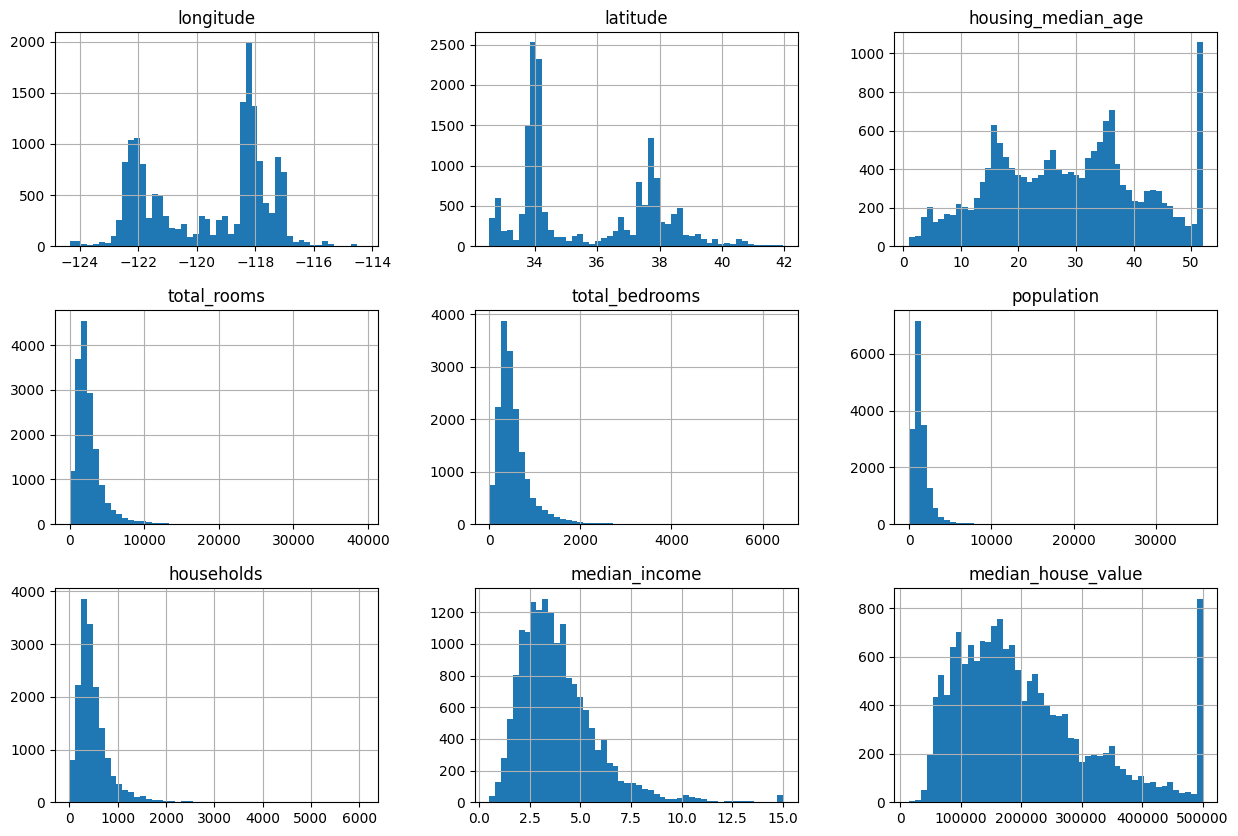

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

train_set.hist(bins=50, ax=ax)
plt.show()

The takeaways from the histograms are:

1. `median_income` attribute is not expressed in US dollars. Actually, the data has been scaled and capped at 15 for higher median incomes and at 0.5 for lower median income. The numbers represents tens of thousands.
2. `house_median_age` and `median_house_value` were also capped. This is worrisome because `median_house_value` is our target variable, and the ML model might interpret that prices never go beyond 500.000.
3. The attributes are unscaled and the histogramas are tail-heavy, whick makes it a bit harde for ML algorithms to detect patterns.

In [7]:
train_set["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     7341
INLAND        5227
NEAR OCEAN    2086
NEAR BAY      1854
ISLAND           4
Name: count, dtype: int64

For the categorical variable `ocean_proximity`, we have 5 categories, being `INLAND` the most frequent, and `ISLAND` the less frequency. 

Let's investigate the geographical information about the records.

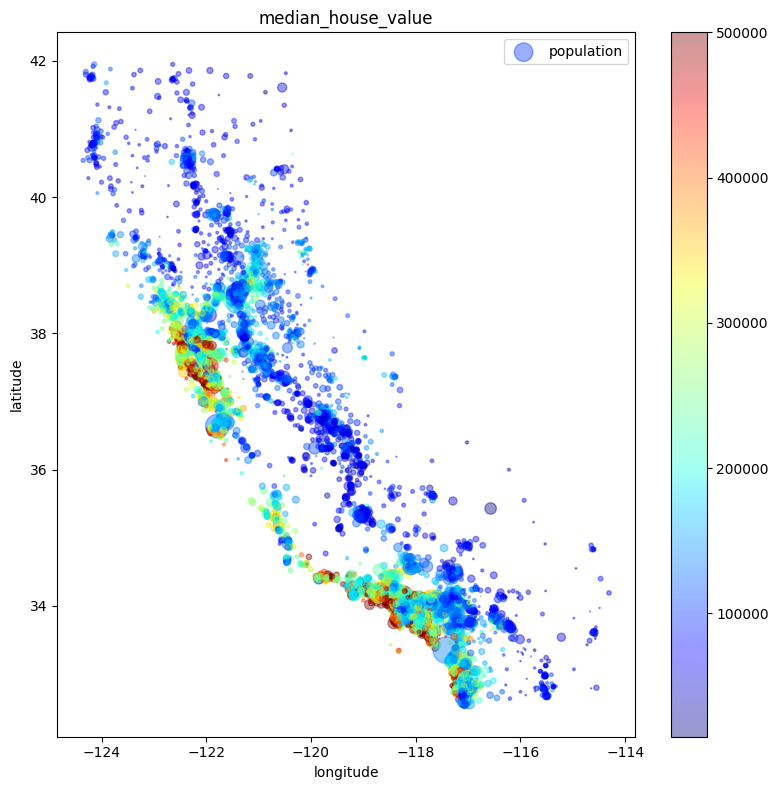

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

train_set.plot(kind="scatter", 
               x="longitude", 
               y="latitude", 
               alpha=0.4, 
               s=train_set["population"]/100, 
               label="population", 
               c=train_set["median_house_value"],
               cmap=plt.get_cmap("jet"), 
               colorbar=True,
               ax=ax)

ax.set_title("median_house_value")
ax.legend()

plt.tight_layout()
plt.show()

As expected, houses closer to the ocean (left side of the plot) are more expensive. 

As said in the beginning, each row represents a district. Thus, `total_rooms` and `total_bedrooms` are not very useful, considering they are absolute measures. To get away with that, we can create relative variables, such as:

- `rooms_per_household`
- `bedrooms_per_room`
- `population_per_household`

We could think of several other ways to improve our feature set. However, this is not the focus of this notebook, so let's proceed to data preparation.

## 4. Data Preparation

As we saw in the beginning of the notebook, the dataset has some missing value entries. However, some ML algorithms don't missing values. To fill the missing entries, we are going to simply adopt the median value of their respective feature.

Also, as suggested in the end of the last section, we can create new features to achieve a better feature set. That's what we are going to do below:

**Feature Engineering**

To prepare the dataset, we are going to construct a preprocessor pipeline compatible with scikit-learn. We could simply apply the necessary transformations to the dataset, and make it to the model training, but that wouldn't be so fun!

In [9]:
columns = train_set.columns.tolist()

rooms_ix = columns.index("total_rooms")
bedrooms_ix = columns.index("total_bedrooms")
population_ix = columns.index("population")
households_ix = columns.index("households")

class AddEngineeredFeatures(BaseEstimator, TransformerMixin):
    """Create relative features"""
    def __init__(self): # no *args or **kargs
        pass
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

**Missing Value Imputation**

To fill the missing values, we are going to use the median value of each future by simply applying the object `SimpleImputer(strategy="median"))` to them. However, this strategy is only applicable to numerical features. Therefore, we are going to create a separate pipeline to apply transformations to the numerical features only.

In [10]:
features_numerical = train_set.drop(columns="ocean_proximity").columns.tolist()
features_categorical = ["ocean_proximity"]

# SimpleImputer(strategy="median") only applies to numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', AddEngineeredFeatures())
])

We could also create a pipeline to preprocess the categorical feature `ocean_proximity`. For instance, we could apply one hot encoding to that feature. However, since we'll use CatBoost as our regression model, and CatBoost natively supports categorical features, we won't get into the trouble of preprocessing that feature.

In [11]:
preprocessor = ColumnTransformer(
    transformers=[("numerical", numerical_pipeline, features_numerical)], 
    remainder="passthrough"
    )

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

Fit and apply the pipeline to the train and test sets:

In [12]:
pipeline.fit(train_set)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   AddEngineeredFeatures())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'median_house_value'])]))])

In [13]:
extra_cols = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
 
train_set = pd.DataFrame(data=pipeline.transform(train_set), 
                         columns=features_numerical + extra_cols + features_categorical)

test_set = pd.DataFrame(data=pipeline.transform(test_set),
                        columns=features_numerical + extra_cols + features_categorical)

## 5. Model Training

In [ ]:
X_train, y_train = train_set.drop(columns="median_house_value"), train_set["median_house_value"]
X_test, y_test = test_set.drop(columns="median_house_value"), train_set["median_house_value"]

In [ ]:
class QuantileCatBoostRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lower_model, upper_model):
        self.lower_model = lower_model
        self.upper_model = upper_model

    def fit(self, X, y):
        print("[INFO] Fitting 10th percentile model")
        self.lower_model.fit(X, y)
        
        print("[INFO] Fitting 90th percentile model")
        self.upper_model.fit(X, y)
        return self

    def predict(self, X):
        lower_quantiles = self.lower_model.predict(X)
        upper_quantiles = self.upper_model.predict(X)
        return np.c_[lower_quantiles, upper_quantiles]

In [21]:
model_upper = CatBoostRegressor(loss_function="Quantile:alpha=0.9", 
                                cat_features=["ocean_proximity"],
                                verbose=200)

model_lower = CatBoostRegressor(loss_function="Quantile:alpha=0.1", 
                                cat_features=["ocean_proximity"],
                                verbose=200)

In [26]:
model = QuantileCatBoostRegressor(model_lower, model_upper)

In [27]:
model.fit(X_train, y_train)

0:	learn: 14085.0068108	total: 29.6ms	remaining: 29.6s
200:	learn: 7165.2085761	total: 3.1s	remaining: 12.3s
400:	learn: 6292.0912373	total: 5.39s	remaining: 8.05s
600:	learn: 5854.5835279	total: 8.04s	remaining: 5.34s
800:	learn: 5616.4907764	total: 10.3s	remaining: 2.57s
999:	learn: 5440.4941219	total: 12.6s	remaining: 0us
0:	learn: 25100.3245590	total: 13.4ms	remaining: 13.4s
200:	learn: 10604.1781956	total: 2.02s	remaining: 8.04s
400:	learn: 9166.7787200	total: 4.17s	remaining: 6.23s
600:	learn: 8274.1601937	total: 6.28s	remaining: 4.17s
800:	learn: 7787.7518963	total: 8.6s	remaining: 2.14s
999:	learn: 7441.3847061	total: 10.8s	remaining: 0us


QuantileCatBoostRegressor(lower_model=<catboost.core.CatBoostRegressor object at 0x7fa61476c850>,
                          upper_model=<catboost.core.CatBoostRegressor object at 0x7fa60c529c40>)

In [28]:
model.predict(X_train)

array([[102136.52245521, 139190.70288059],
       [255190.66265072, 452879.33919487],
       [148483.58621529, 275141.72763867],
       ...,
       [171179.95760264, 259230.603491  ],
       [237312.93331423, 330685.05051929],
       [230933.1386346 , 427599.66329411]])